In [9]:
import pickle
# import tensorflow as tf
import redshift_connector
import pandas as pd
pd.set_option("display.max_colwidth", None)
import numpy as np
# from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from collections import Counter
from math import ceil
# from transformers import RobertaTokenizer, RobertaTokenizerFast, TFRobertaModel

In [8]:
# !pip install redshift-connector
# !pip install pandas
# !pip install matplotlib

In [10]:
with open("redshift_creds.txt", "r") as f:
    host = f.readline()[:-1]
    password= f.readline()[:-1]

In [11]:
conn = redshift_connector.connect(
     host=host,
     database='dev',
     user='app_user',
     password=password
  )

In [12]:
# conn.close()

In [13]:
cursor = conn.cursor()

#### Looking at all tables needed

In [16]:
cursor.execute("ROLLBACK;")
cursor.execute("SELECT DISTINCT tablename FROM pg_table_def")
result = cursor.fetchall()
for i in result:
    print(i[0])

account_institutions
admin_view_dependencies
cdl_journals_before_perpetual_access
cdl_journals_before_perpetual_access_with_issnl_view
cdl_journals_temp
cdl_journals_temp_with_issn_l_view
cdl_journals_temp_with_issn_l_view_old
counter_old
crkn_perpetual_access_backup_2020_06_30
crossref_2017_dois_fresh
crossref_abstract_length
crossref_dois_fresh_dates
crossref_journal_raw
crossref_journal_view
crossref_main_affiliation
crossref_main_author
crossref_main_reference
crossref_main_works
crossref_raw
crossref_raw_direct
crossref_raw_last2days
crossref_reference_raw_direct
doaj_journal_issnl_view
doaj_journal_issns_view
doaj_journals_raw
grid_addresses
grid_base
hap_bianca_dois
hap_kbart
hap_temp
iso_country_codes
journal_delayed_oa_active
journal_delayed_oa_candidates
journal_delayed_oa_data_view
journal_prices
journal_prices_bak_20200520
journal_prices_bak_20201130
journal_prices_raw
journal_prices_raw_20201126
journal_prices_raw_bak
journal_prices_raw_bak_20200520
journalsdb_computed
jou

#### Checking the column names for a specific table

In [13]:
query = """SELECT *
  FROM information_schema.columns
 WHERE table_name   = 'mag_advanced_fields_of_study'"""

cursor.execute("ROLLBACK;")
cursor.execute(query)
result = cursor.fetchall()
for i in result:
    print(i[3])

level
create_date
main_type
display_name
normalized_name
rank
citation_count
paper_family_count
paper_count
field_of_study_id


#### Getting Field of Study and Associated ID

In [14]:
query = """select normalized_name, field_of_study_id
from mag_advanced_fields_of_study"""

In [15]:
cursor.execute("ROLLBACK;")
cursor.execute(query)
tags_df = cursor.fetch_dataframe()
tags_df.shape

(718697, 2)

In [18]:
tags_df.to_parquet("fields_of_study_ids.parquet")

#### Getting Orphans

In [22]:
query = """select field_of_study_id, normalized_name, level	 
from mag_advanced_fields_of_study
where field_of_study_id not in (select child_field_of_study_id 
                                from mag_advanced_field_of_study_children)
and level > 0
and paper_count >=100
order by paper_count desc"""

In [23]:
cursor.execute("ROLLBACK;")
cursor.execute(query)
df = cursor.fetch_dataframe()
df.shape

(12813, 3)

In [24]:
df.head(20)

,field_of_study_id,normalized_name,level
0,2908647359,population,2
1,3018028166,in patient,3
2,3020570323,preparation method,2
3,3017944768,poison control,2
4,3018420607,control methods,2
5,2910001868,european union,2
6,3013748606,human immunodeficiency virus,2
7,3018023364,significant difference,2
8,2984729377,high pressure,2
9,2982719155,energy source,3


In [11]:
df['level'].value_counts()

2    7147
3     681
Name: level, dtype: int64

In [25]:
df.to_parquet("mag_imitator_orphans.parquet")

### Looking at some papers

##### The following query "explodes" the hierarchy to add tags. Not sure if this method will be used in training. Might stick with the given tags so that the model does not get confused. I don't think I want multiple level 0s to be tagged every time which is what seems might happen if the exploding hierarchy is used.

In [240]:
journal_join_query = \
"""
SELECT  a.paper_id, a.doc_type, a.paper_title, a.year, 
        a.publication_date, a.journal_id, b.normalized_name,
        c.field_of_study, d.normalized_name as topic_name, d.display_name,
        d.rank, f.parent_name, f.parent_level, h.parent2_name, h.parent2_level,
        j.parent3_name, j.parent3_level
FROM (SELECT paper_id, doc_type, paper_title, book_title, year, 
             publication_date, online_date, journal_id
      FROM mag_main_papers 
      WHERE paper_id=2216470333) a
LEFT JOIN (SELECT journal_id, normalized_name
           FROM mag_main_journals) b
ON a.journal_id=b.journal_id
LEFT JOIN (SELECT *
           FROM mag_advanced_paper_fields_of_study) c
ON a.paper_id=c.paper_id
LEFT JOIN (SELECT *
           FROM mag_advanced_fields_of_study) d
ON c.field_of_study=d.field_of_study_id
LEFT JOIN (SELECT field_of_study_id as parent_field_of_study_id, 
                  child_field_of_study_id
           FROM mag_advanced_field_of_study_children) e
ON c.field_of_study=e.child_field_of_study_id
LEFT JOIN (SELECT normalized_name as parent_name, field_of_study_id, 
                  level as parent_level
           FROM mag_advanced_fields_of_study) f
ON f.field_of_study_id=e.parent_field_of_study_id
LEFT JOIN (SELECT field_of_study_id as parent2_field_of_study_id, 
                  child_field_of_study_id
           FROM mag_advanced_field_of_study_children) g
ON e.parent_field_of_study_id=g.child_field_of_study_id
LEFT JOIN (SELECT normalized_name as parent2_name, field_of_study_id, 
                  level as parent2_level
           FROM mag_advanced_fields_of_study) h
ON h.field_of_study_id=g.parent2_field_of_study_id
LEFT JOIN (SELECT field_of_study_id as parent3_field_of_study_id, 
                  child_field_of_study_id
           FROM mag_advanced_field_of_study_children) i
ON g.parent2_field_of_study_id=i.child_field_of_study_id
LEFT JOIN (SELECT normalized_name as parent3_name, field_of_study_id, 
                  level as parent3_level
           FROM mag_advanced_fields_of_study) j
ON j.field_of_study_id=i.parent3_field_of_study_id
"""

### -------------------------------------------

##### The following query is to attach the journal and tag name info to each paper

In [124]:
journal_join_query = \
"""
SELECT  a.paper_id, a.doc_type, a.paper_title, a.year, 
        a.publication_date, b.normalized_name as journal_name,
        d.normalized_name as topic_name, d.level, 
        h.normalized_name as affiliation_name
FROM (SELECT paper_id, doc_type, paper_title, book_title, year, 
             publication_date, online_date, journal_id
      FROM mag_main_papers 
      WHERE random() <= .004) a
LEFT JOIN (SELECT journal_id, normalized_name
           FROM mag_main_journals) b
ON a.journal_id=b.journal_id
LEFT JOIN (SELECT *
           FROM mag_advanced_paper_fields_of_study) c
ON a.paper_id=c.paper_id
LEFT JOIN (SELECT *
           FROM mag_advanced_fields_of_study) d
ON c.field_of_study=d.field_of_study_id
LEFT JOIN (SELECT paper_id, affiliation_id
           FROM mag_main_paper_author_affiliations
           GROUP BY paper_id, affiliation_id) f
ON f.paper_id=a.paper_id
LEFT JOIN (SELECT *
           FROM mag_main_affiliations) h
ON h.affiliation_id=f.affiliation_id
"""

In [125]:
cursor.execute("ROLLBACK;")
cursor.execute(journal_join_query)
df = cursor.fetch_dataframe()
df.shape

(7913587, 9)

In [126]:
df.columns

Index(['paper_id', 'doc_type', 'paper_title', 'year', 'publication_date',
       'journal_name', 'topic_name', 'level', 'affiliation_name'],
      dtype='object')

In [95]:
df['paper_id'].value_counts()

2907219204    1570
2894662039     510
2612100421     440
2524369660     385
1733892693     312
              ... 
2598125376       1
844473241        1
583274528        1
2765649862       1
2784925087       1
Name: paper_id, Length: 103778, dtype: int64

In [96]:
df['paper_id'].value_counts().mean()

7.621307020755844

#### This was done as a test to see how an explosion would work for a single paper (using explosion query above)

In [244]:
len([x for x in list(set(df['parent_name'].unique().tolist() + 
                         df['topic_name'].unique().tolist() + 
                         df['parent2_name'].unique().tolist() + 
                         df['parent3_name'].unique().tolist())) if x is not None])

23

In [245]:
df[df['paper_id']==2216470333]

,paper_id,doc_type,paper_title,year,publication_date,journal_id,normalized_name,field_of_study,topic_name,display_name,rank,parent_name,parent_level,parent2_name,parent2_level,parent3_name,parent3_level
0,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,creatinine,2.0,biochemistry,1.0,chemistry,0.0
1,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,198684833,specific activity,Specific activity,10858,enzyme,2.0,biochemistry,1.0,chemistry,0.0
2,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,urine,2.0,biochemistry,1.0,chemistry,0.0
3,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,excretion,2.0,biochemistry,1.0,chemistry,0.0
4,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,198684833,specific activity,Specific activity,10858,enzyme,2.0,organic chemistry,1.0,chemistry,0.0
5,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,urinary system,2.0,anatomy,1.0,medicine,0.0
6,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,urinary system,2.0,endocrinology,1.0,medicine,0.0
7,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,creatinine,2.0,endocrinology,1.0,medicine,0.0
8,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,urine,2.0,endocrinology,1.0,medicine,0.0
9,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,excretion,2.0,endocrinology,1.0,medicine,0.0


### ------------------------------------------------------

In [265]:
df.drop_duplicates(subset=['paper_id'])['doc_type'].value_counts()

Journal        35333
Patent         25883
Thesis          2172
Conference      1977
Repository      1925
Book            1747
BookChapter     1506
Dataset           52
Name: doc_type, dtype: int64

In [266]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617664 entries, 0 to 617663
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   paper_id          617664 non-null  int64  
 1   doc_type          492117 non-null  object 
 2   paper_title       617664 non-null  object 
 3   year              617493 non-null  float64
 4   publication_date  617493 non-null  object 
 5   journal_id        285925 non-null  float64
 6   journal_name      285925 non-null  object 
 7   field_of_study    595481 non-null  float64
 8   topic_name        595481 non-null  object 
 9   display_name      595481 non-null  object 
 10  level             595481 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 51.8+ MB


In [267]:
df[df['field_of_study'].isnull()].sample(5)

,paper_id,doc_type,paper_title,year,publication_date,journal_id,journal_name,field_of_study,topic_name,display_name,level
587129,2596657702,Journal,buch anzeigen practische notiz,1895.0,1895-01-01,135397728.0,dermatology,NaN,None,None,NaN
562060,2895693277,None,elaboracao de produtos alimenticios a partir d...,2018.0,2018-10-02,NaN,None,NaN,None,None,NaN
583491,587614821,None,モニター心電図 かんたん マスター 第21回 part3 急変で出会う不整脈事例 10 ペー...,2006.0,2006-09-01,NaN,None,NaN,None,None,NaN
612627,2563424288,None,korelasi panjang baku dan berat ikan arius cae...,2016.0,2016-04-18,NaN,None,NaN,None,None,NaN
547509,889394325,None,螺旋人生 记我国锥齿轮专家 洛阳工学院教授梁桂明,2000.0,2000-01-01,NaN,None,NaN,None,None,NaN


### Used the following code to check language of the title and run some stats on those vs field of study being blank

In [153]:
from langdetect import detect

In [154]:
temp_df = df.drop_duplicates(subset=['paper_id']).copy()

In [155]:
def get_lang(x):
    try:
        lang = detect(x)
    except:
        lang = 'UNK'
    return lang

In [156]:
temp_df['lang'] = temp_df['paper_title'].apply(lambda x: get_lang(x))

In [157]:
temp_df.head(5)

,paper_id,doc_type,paper_title,year,publication_date,journal_id,normalized_name,field_of_study,normalized_name,display_name,rank,main_type,level,lang
0,1722040101,Journal,the development of larval resistance to a nucl...,2000.0,2000-09-01,172494440.0,evolutionary ecology,8.680324e+07,biology,Biology,4432,None,0.0,en
1,2226449916,Patent,electric contact element for electrochemical d...,2000.0,2000-12-05,NaN,None,6.880162e+07,electrolyte,Electrolyte,8064,None,3.0,en
2,2239066496,None,samuel wetherill s self publishing or quaker d...,2014.0,2014-01-08,NaN,None,2.777800e+09,independence,Independence,10140,media_common.quotation_subject,2.0,en
3,2752449863,Journal,commercial intravenous immunoglobulin preparat...,2017.0,2017-11-01,47215897.0,antimicrobial agents and chemotherapy,2.777806e+09,leukocidin,Leukocidin,13609,None,4.0,en
4,2300157463,Patent,method and system for locating devices during ...,1999.0,1999-03-18,NaN,None,1.274136e+08,engineering,Engineering,4855,business.industry,0.0,en


### Looking at the sample of data to see which % of english and non-english papers have a field of study

In [160]:
temp_df.shape[0]

104017

#### % That are english and have field of study out of all english

In [162]:
(temp_df[(temp_df['lang']=='en') & (~temp_df['field_of_study'].isnull())].shape[0])/ \
(temp_df[(temp_df['lang']=='en')].shape[0])*100

97.42521513454446

#### % That are english and no field of study out of all english

In [164]:
(temp_df[(temp_df['lang']=='en') & (temp_df['field_of_study'].isnull())].shape[0])/ \
(temp_df[(temp_df['lang']=='en')].shape[0])*100

2.574784865455539

#### % That are non-english and have field of study out of all non-english

In [165]:
(temp_df[(temp_df['lang']!='en') & (~temp_df['field_of_study'].isnull())].shape[0])/ \
(temp_df[(temp_df['lang']!='en')].shape[0])*100

32.93082740935502

#### % That are non-english and no field of study out of all non-english

In [166]:
(temp_df[(temp_df['lang']!='en') & (temp_df['field_of_study'].isnull())].shape[0])/ \
(temp_df[(temp_df['lang']!='en')].shape[0])*100

67.06917259064498

In [168]:
(temp_df[(temp_df['lang']!='en') & (temp_df['field_of_study'].isnull())].shape[0])/ \
(temp_df.shape[0])*100

19.864060682388455

#### % of sample papers for the top 10 languages

In [159]:
(temp_df['lang'].value_counts()/temp_df.shape[0]*100)[:10]

en       70.382726
fr        3.770538
es        3.352337
de        3.113914
ja        3.089880
ko        2.491900
it        2.132344
pt        1.537249
zh-cn     1.335359
id        1.271907
Name: lang, dtype: float64

In [167]:
temp_df[(temp_df['lang']!='en') & (~temp_df['field_of_study'].isnull())].sample(20)

,paper_id,doc_type,paper_title,year,publication_date,journal_id,normalized_name,field_of_study,normalized_name,display_name,rank,main_type,level,lang
363146,2022025267,None,l occupation militaire pouvoirs reconnus aux f...,1962.0,1962-01-01,NaN,None,1.774444e+07,political science,Political science,6001,None,0.0,fr
372549,2561793121,None,verbalni komunikace a lidska psychika,2007.0,2007-01-01,NaN,None,1.574497e+07,psychology,Psychology,5223,None,0.0,hr
23000,2997029165,None,upaya pemerintah jepang dalam perelokasian pan...,2018.0,2018-07-07,NaN,None,1.961792e+08,economic problem,Economic problem,11779,None,2.0,id
56676,2064224311,Conference,a vertical distribution ltcc duplexer,2011.0,2011-11-03,NaN,None,2.432624e+07,electronic engineering,Electronic engineering,6389,None,1.0,ca
150960,3146167721,Patent,pet traction device,2019.0,2019-07-16,NaN,None,9.390403e+06,computer hardware,Computer hardware,6781,business.industry,1.0,fr
51792,2927375358,Patent,multi channel laser output device,2014.0,2014-08-11,NaN,None,1.195995e+08,electrical engineering,Electrical engineering,6022,business.industry,1.0,fr
421323,2850259760,Patent,procede et machine de poinconnage de pieces de...,2012.0,2012-09-28,NaN,None,1.925624e+08,materials science,Materials science,4137,None,0.0,fr
18318,210506594,None,カイワレ栽培における成長とカチオン ca mg k 含有量に及ぼす磁場と音波の効果,2008.0,2008-06-01,NaN,None,1.152607e+08,magnetic field,Magnetic field,7809,None,2.0,ja
10980,3110519847,Patent,coating glue supply temperature control device,2020.0,2020-07-24,NaN,None,2.012897e+08,inlet,Inlet,7804,geography.geographical_feature_category,2.0,it
303500,1552380730,Book,droit international prive,1987.0,1987-01-01,NaN,None,1.774444e+07,political science,Political science,6001,None,0.0,fr


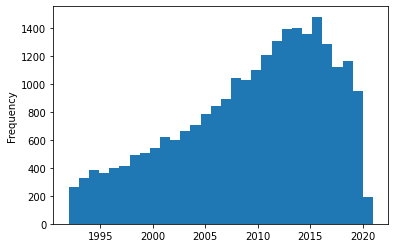

In [284]:
# histogram showing journals of the past 30 years that are not in english (on its way down after peaking in ~2013)
temp_df[(temp_df['lang']!='en') & (temp_df['year'] > 1991)]['year'].plot.hist(bins=30)
plt.show()

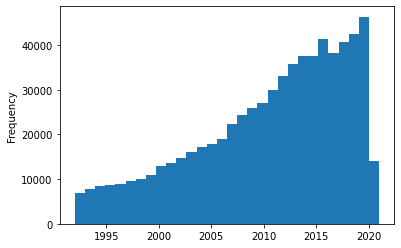

In [100]:
# histogram showing the total number of journals being published each year
df[df['year'] > 1991]['year'].plot.hist(bins=30)
plt.show()

#### Check Journals

In [92]:
cursor.execute("ROLLBACK;")
cursor.execute("SELECT * FROM mag_main_journals")
df = cursor.fetch_dataframe()

#### Check Field of Study

In [146]:
cursor.execute("ROLLBACK;")
cursor.execute("SELECT * FROM mag_advanced_fields_of_study")
mag_fields = cursor.fetch_dataframe()
mag_fields.shape

(718697, 10)

In [147]:
mag_fields['level'].value_counts()

3.0    357425
2.0    159323
4.0    124331
5.0     77303
1.0       292
0.0        19
Name: level, dtype: int64

In [149]:
mag_fields[mag_fields['level']==0.0]

,field_of_study_id,rank,normalized_name,display_name,main_type,level,paper_count,paper_family_count,citation_count,create_date
12099,127313418,5728,geology,Geology,None,0.0,7229938.0,7146333.0,39081212.0,2016-06-24
73790,205649164,6293,geography,Geography,None,0.0,4577091.0,4555936.0,21098112.0,2016-06-24
110692,185592680,4358,chemistry,Chemistry,None,0.0,18501883.0,17694356.0,238074571.0,2016-06-24
129233,33923547,5125,mathematics,Mathematics,None,0.0,6999822.0,6698419.0,81954218.0,2016-06-24
131082,192562407,4137,materials science,Materials science,None,0.0,30842052.0,29409414.0,173450325.0,2016-06-24
131509,138885662,7248,philosophy,Philosophy,None,0.0,2086370.0,2081982.0,5001790.0,2016-06-24
207151,41008148,4250,computer science,Computer science,None,0.0,26826626.0,25672825.0,151405340.0,2016-06-24
270489,17744445,6001,political science,Political science,None,0.0,6751171.0,6690167.0,21566953.0,2016-06-24
293109,39432304,5852,environmental science,Environmental science,None,0.0,6190085.0,6121022.0,36169558.0,2016-06-24
294653,15744967,5223,psychology,Psychology,None,0.0,7998148.0,7954010.0,111798077.0,2016-06-24


#### Explored patents as a feature but most likely won't work
* thought about possibly connecting through a patent API to get more information on the paper
* patent ID was sparse but also did not match up with patent database
* could possibly work with author but wouldn't be a one-to-one match every time (something that could be made to work with extra effort)

#### Looking into affiliations
* determined that it might be beneficial to add as a feature later but as of right now I will keep it out of the model

In [149]:
df.sample(10)

,paper_id,doc_type,paper_title,year,publication_date,journal_name,topic_name,level,affiliation_name
6798592,2607443536,Journal,analise histologica das brânquias e do figado ...,2017.0,2017-04-19,boletim do instituto de pesca,histology,2.0,federal university of maranhao
3618526,2872829737,Patent,information reproducing and recording device,1986.0,1986-04-24,None,synchro,2.0,None
6259769,2140391383,Journal,student loan reforms for german higher educati...,2014.0,2014-07-24,education economics,government,2.0,australian national university
56345,1977871706,Journal,reducing 30 day rehospitalization,2012.0,2012-02-07,annals of internal medicine,systematic review,3.0,northwestern university
4674002,200032764,None,linear systems and projection,1999.0,1999-01-01,None,parallel projection,3.0,university of chicago
2861311,2153140228,None,libguides research in music listen watch,2009.0,2009-05-13,None,music education,2.0,None
7812909,2131250445,Journal,simultaneous tumors acute myeloid leukemia inf...,2011.0,2011-02-01,pediatric blood & cancer,pediatric hematology oncology,2.0,None
6782890,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,transformer,3.0,national taiwan university
2372499,1988968993,Journal,sets of convergence of ordinary dirichlet series,1954.0,1954-12-01,duke mathematical journal,dirichlet l function,5.0,None
682892,2750795160,Conference,fiber wireless convergence for next generation...,2017.0,2017-07-01,None,interface,2.0,georgia institute of technology


In [97]:
df.drop_duplicates(subset=['paper_id']).dropna(subset=['topic_name']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81364 entries, 0 to 787911
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   paper_id          81364 non-null  int64  
 1   doc_type          62867 non-null  object 
 2   paper_title       81364 non-null  object 
 3   year              81338 non-null  float64
 4   publication_date  81339 non-null  object 
 5   journal_name      35120 non-null  object 
 6   topic_name        81364 non-null  object 
 7   level             81364 non-null  float64
 8   affiliation_name  22795 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 6.2+ MB


In [84]:
df['affiliation_name'].value_counts()

chinese academy of sciences                     2291
harvard university                              1869
centre national de la recherche scientifique    1579
max planck society                              1537
university of michigan                          1526
                                                ... 
centrotherm photovoltaics                          1
peruvian academy of language                       1
consejo nacional de ciencia y tecnologia           1
northrop grumman                                   1
jenderal soedirman university                      1
Name: affiliation_name, Length: 6549, dtype: int64

In [150]:
df[df['paper_id']==2104224477].head(40)

,paper_id,doc_type,paper_title,year,publication_date,journal_name,topic_name,level,affiliation_name
246172,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,tap changer,4.0,national taiwan university
349587,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,control theory,1.0,national taiwan university
693790,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,ac power,3.0,national taiwan university
1841697,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,voltage optimisation,4.0,national taiwan university
2069238,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,power factor,3.0,national taiwan university
3435757,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,distribution transformer,4.0,national taiwan university
4244911,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,engineering,0.0,national taiwan university
5401568,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,voltage regulation,3.0,national taiwan university
6437439,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,voltage regulator,3.0,national taiwan university
6782890,2104224477,Journal,fuzzy dynamic programming approach to reactive...,1997.0,1997-05-01,ieee transactions on power systems,transformer,3.0,national taiwan university


In [90]:
df[df['paper_id']==2947431322]['topic_name'].value_counts()

colorectal cancer                78
genetics                         78
genome wide association study    78
genetic association              78
biology                          78
genetic predisposition           78
Name: topic_name, dtype: int64

In [91]:
df[df['paper_id']==2947431322]['affiliation_name'].value_counts()

university of tennessee health science center    6
university hospitals of cleveland                6
city of hope national medical center             6
memorial sloan kettering cancer center           6
american cancer society                          6
                                                ..
cleveland clinic                                 6
university of hamburg                            6
national university of singapore                 6
memorial university of newfoundland              6
kaiser permanente                                6
Name: affiliation_name, Length: 77, dtype: int64

#### Looking at the target variable

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7913587 entries, 0 to 7913586
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   paper_id          int64  
 1   doc_type          object 
 2   paper_title       object 
 3   year              float64
 4   publication_date  object 
 5   journal_name      object 
 6   topic_name        object 
 7   level             float64
 8   affiliation_name  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 543.4+ MB


#### Average number of topics assigned to each paper:

In [128]:
df.drop(['affiliation_name'], axis=1).drop_duplicates().dropna(subset=['topic_name']) \
['paper_id'].value_counts().mean()

7.330412429350789

#### Distribution of number of topics assigned to a paper

<AxesSubplot:xlabel='num_topics'>

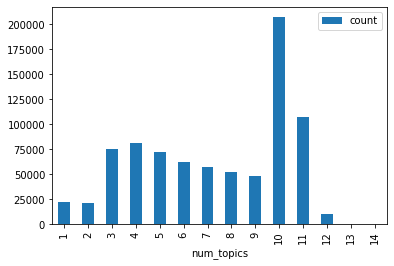

In [162]:
df.drop(['affiliation_name'], axis=1).drop_duplicates().dropna(subset=['topic_name']) \
['paper_id'].value_counts().reset_index().rename(columns={'paper_id':'num_topics'}) \
.groupby('num_topics').count().rename(columns={'index':'count'}).plot.bar()

In [163]:
df.drop(['affiliation_name'], axis=1).drop_duplicates().dropna(subset=['topic_name']) \
['paper_id'].value_counts().reset_index().rename(columns={'paper_id':'num_topics'}) \
.groupby('num_topics').count().rename(columns={'index':'count'})

,count
num_topics,
1,21938
2,21055
3,74640
4,80660
5,71626
6,62477
7,56735
8,52305
9,48254


#### Going through topics to see counts of each topic

In [129]:
topics = df.drop(['affiliation_name'], axis=1).drop_duplicates().dropna(subset=['topic_name']) \
.groupby('paper_id')['topic_name'].apply(list).to_list()

In [130]:
final_topics_list = [x for y in topics for x in y]

In [131]:
len(final_topics_list)

5971266

In [133]:
counts = Counter(final_topics_list)

In [135]:
testing_counts = pd.DataFrame(counts.items(), columns=['topic','count'])

In [137]:
testing_counts.shape

(193454, 2)

In [147]:
testing_counts[testing_counts['count'] < 5].shape

(122429, 2)

<AxesSubplot:ylabel='Frequency'>

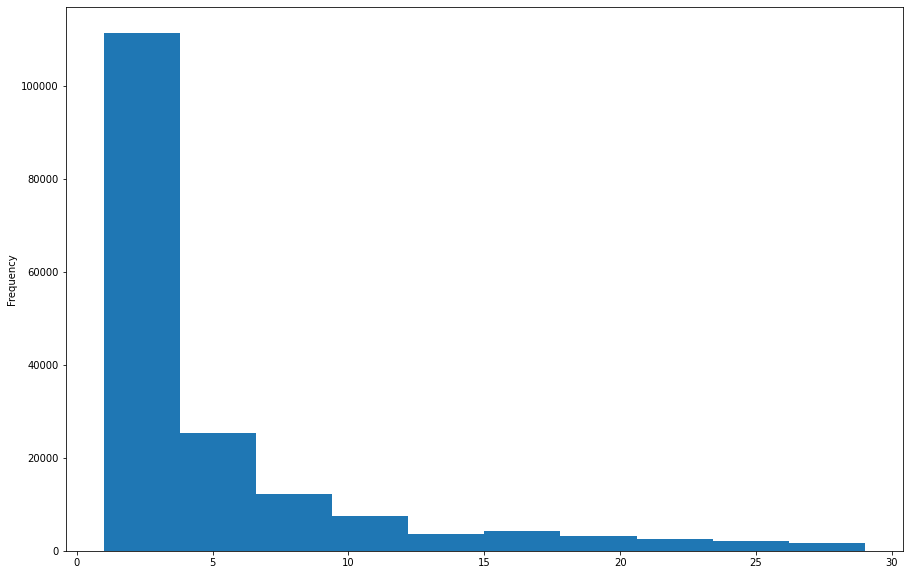

In [146]:
testing_counts[testing_counts['count'] < 30]['count'].plot.hist(figsize=(15,10),bins=10)

#### Trying to get Redshift to do the heavy lifting

In [9]:
journal_join_query = \
"""
SELECT paper_id, doc_type, paper_title, journal_name, publication_date, listagg(topic_name, '|') topics
FROM (
SELECT  a.paper_id, a.doc_type, a.paper_title, a.year, 
        a.publication_date, b.normalized_name as journal_name,
        d.normalized_name as topic_name, d.level
FROM (SELECT paper_id, doc_type, paper_title, book_title, year, 
             publication_date, online_date, journal_id
      FROM mag_main_papers 
      WHERE random() <= .1) a
LEFT JOIN (SELECT journal_id, normalized_name
           FROM mag_main_journals) b
ON a.journal_id=b.journal_id
LEFT JOIN (SELECT *
           FROM mag_advanced_paper_fields_of_study) c
ON a.paper_id=c.paper_id
LEFT JOIN (SELECT *
           FROM mag_advanced_fields_of_study) d
ON c.field_of_study=d.field_of_study_id )
WHERE topic_name IS NOT NULL
GROUP BY paper_id, doc_type, paper_title, journal_name, publication_date
"""

In [10]:
%%time
cursor.execute("ROLLBACK;")
cursor.execute(journal_join_query)
df = cursor.fetch_dataframe()
df.shape

CPU times: user 3min 42s, sys: 2min 18s, total: 6min
Wall time: 8min 46s


(20348766, 6)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20348766 entries, 0 to 20348765
Data columns (total 6 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   paper_id          int64 
 1   doc_type          object
 2   paper_title       object
 3   journal_name      object
 4   publication_date  object
 5   topics            object
dtypes: int64(1), object(5)
memory usage: 931.5+ MB


In [12]:
df['topics'] = df['topics'].apply(lambda x: x.split("|"))

In [14]:
df['publication_date'] = pd.to_datetime(df['publication_date'])

In [7]:
# df.to_parquet("test_data_to_try.parquet")

In [8]:
df = pd.read_parquet("test_data_to_try.parquet")

In [9]:
df.shape

(20348766, 6)

In [14]:
df['publication_date'].min()

Timestamp('1800-01-01 00:00:00')

In [15]:
df['publication_date'].max()

Timestamp('2022-01-01 00:00:00')

In [20]:
df.dropna(subset=['publication_date']).sort_values('publication_date').head(50)

,paper_id,doc_type,paper_title,journal_name,publication_date,topics
15293684,2772991433,None,report put reading first for parents,None,1800-01-01,"[reading, psychology, mathematics education]"
7589758,1582345295,Book,versuch einer geschichte der kultur des menschlichen geschlechts,None,1800-01-01,[philosophy]
5230827,2567918209,None,dictionnaire de l academie francoise,None,1800-01-01,[art]
7524144,2467735828,None,overture to the opera of fra diavolo,None,1800-01-01,"[art, humanities, opera]"
9267305,2593091787,None,strain analyses of nonlinear crack behavior at elevated temperature by finite element method and moire topographical method,None,1800-01-01,"[engineering drawing, finite element method, moire pattern, composite material, materials science, strain, nonlinear system]"
20280717,2491217040,None,xv explanation of a seal of the abbey of lundores in scotland by the rev john brand secretary in a letter addressed to owen salusbury brereton esq vice president,None,1800-01-01,"[pece, seal, saint, theology, law, history, vice president]"
6759308,2622545586,None,a comparison of observed behaviors of four year olds with theory predicted behaviors extrapolated from freud s and kohlberg s theories of psychosexual development,None,1800-01-01,"[psychology, psychosexual development, lawrence kohlberg s stages of moral development, developmental psychology]"
3227004,3008377260,Book,periplus of the erythrean sea,None,1800-01-01,"[ancient history, geography]"
14531084,3127251568,Book,poems on several occasions,None,1800-01-01,"[literature, poetry, art]"
5913139,2613628177,None,microfluidics in the undergraduate analytical lab and in outreach projects,None,1800-01-01,"[engineering, outreach, microfluidics, engineering management]"


In [36]:
df[(df['publication_date'] > "1950-01-01") & (df['publication_date'] < "2021-06-01")].shape

(19857210, 6)

In [34]:
df[(df['publication_date'] >= "2021-06-01") & (df['publication_date'] < "2021-10-01")].shape

(5199, 6)

##### Save Train, Test, Val

In [37]:
shuffled_df = df[(df['publication_date'] > "1950-01-01") & 
                 (df['publication_date'] < "2021-06-01")].sample(19857210).copy()

In [40]:
train = shuffled_df.iloc[:19000000,:].copy()
val = shuffled_df.iloc[19000000:, :].copy()

In [41]:
test = df[(df['publication_date'] >= "2021-06-01") & (df['publication_date'] < "2021-10-01")].copy()

In [42]:
train.shape

(19000000, 6)

In [44]:
val.shape

(857210, 6)

In [43]:
test.shape

(5199, 6)

In [46]:
# train.to_parquet("./data/testing/train/train_raw.parquet")
# val.to_parquet("./data/testing/val/val_raw.parquet")
# test.to_parquet("./data/testing/test/test_raw.parquet")

#### Creating the vocabs

In [2]:
train = pd.read_parquet("./data/testing/train/train_raw.parquet")
val = pd.read_parquet("./data/testing/val/val_raw.parquet")
test = pd.read_parquet("./data/testing/test/test_raw.parquet")

In [3]:
def get_value_counts_for_column(data, col_name):
    if type(data.dropna(subset=[col_name]).reset_index(drop=True)[col_name][0])==str:
        counts_df = data[['paper_id', col_name]].dropna().groupby(col_name).count() \
        .rename(columns={'paper_id':'count'}).reset_index().sort_values('count', ascending=False)
    elif type(data.dropna(subset=[col_name]).reset_index(drop=True)[col_name][0])==np.ndarray:
        col_list = data[col_name].to_list()
        flat_col_list = [x for y in col_list for x in y]
        counts = Counter(flat_col_list)
        counts_df = pd.DataFrame(counts.items(), columns=[col_name,'count']).sort_values('count', ascending=False)
    else:
        counts_df = None
        print("Failed")
    
    return counts_df


def create_vocab(data, col_name, cutoff=5, unk_token=True, none_token=True):
    
    val_counts = get_value_counts_for_column(data, col_name)
    
    val_counts.columns = [f"{col_name}_token", "count"]
    
    final_vocab_df = val_counts[val_counts['count'] >= cutoff].copy()
    
    if unk_token & none_token:
        token_list = ["[UNK]"] + ["[NONE]"] + list(final_vocab_df[f"{col_name}_token"])
    elif unk_token:
        token_list = ["[UNK]"] + list(final_vocab_df[f"{col_name}_token"])
    elif none_token:
        token_list = ["[NONE]"] + list(final_vocab_df[f"{col_name}_token"])
    else:
        token_list = list(final_vocab_df[f"{col_name}_token"])
        
    index_list = list(range(1, len(token_list)+1))
    
    final_vocab = dict(zip(token_list, index_list))
    
    return final_vocab

In [63]:
len(create_vocab(train, "topics", cutoff=15, unk_token=False, none_token=False))

181094

In [60]:
len(create_vocab(train, "topics", cutoff=8, unk_token=False, none_token=False))

225299

#### Creating features and target

In [4]:
def tokenize_feature(feature, vocab, unk_token=True, none_token=True, is_target=True):
    if not is_target:
        unk_token_id = vocab.get('[UNK]')
        none_token_id = vocab.get('[NONE]')
        if feature:
            token_feature = [vocab.get(feature, unk_token_id)]
        else:
            token_feature = [none_token_id]
            
    elif is_target:
        token_feature = []
        for part in feature:
            try:
                token_feature.append(vocab[part])
            except:
                pass
        if not token_feature:
            token_feature = 0
    return token_feature

In [5]:
def tokenize_column(data_old, col_name, cutoff=5, unk_token=True, none_token=True, vocab=None):
    data = data_old.copy()
    if not vocab:
        vocab = create_vocab(data, col_name, cutoff, unk_token, none_token)
    else:
        pass
    
    if type(data.dropna(subset=[col_name]).reset_index(drop=True)[col_name][0])==str:
        data[col_name] = data[col_name].apply(lambda x: tokenize_feature(x, vocab, unk_token, none_token, False))
    elif type(data.dropna(subset=[col_name]).reset_index(drop=True)[col_name][0])==np.ndarray:
        data[col_name] = data[col_name].apply(lambda x: tokenize_feature(x, vocab, unk_token, none_token, True))
    else:
        print("Tokenize failure")
    
    return data, vocab

In [6]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [64]:
%%time
train_df, doc_vocab = tokenize_column(train, "doc_type", cutoff=200000, unk_token=True, none_token=True)
train_df, journal_vocab = tokenize_column(train_df, "journal_name", cutoff=4, unk_token=True, none_token=True)
train_df, target_vocab = tokenize_column(train_df, "topics", cutoff=15, unk_token=False, none_token=False)
train_df['paper_title'] = tokenizer(train_df['paper_title'].to_list(), truncation=True)['input_ids']
train_df['paper_title_len'] = train_df['paper_title'].apply(lambda x: len(x))
train_df['paper_title_mask'] = train_df['paper_title_len'].apply(lambda x: x*[1])
train_df = train_df[train_df['topics']!=0]

CPU times: user 53min 35s, sys: 8min 14s, total: 1h 1min 49s
Wall time: 1h 8min 49s


In [65]:
%%time
val_df, _ = tokenize_column(val, "doc_type", cutoff=200000, unk_token=True, none_token=True, vocab=doc_vocab)
val_df, _ = tokenize_column(val_df, "journal_name", cutoff=4, unk_token=True, none_token=True, vocab=journal_vocab)
val_df, _ = tokenize_column(val_df, "topics", cutoff=2, unk_token=False, none_token=False, vocab=target_vocab)
val_df['paper_title'] = tokenizer(val_df['paper_title'].to_list(), truncation=True)['input_ids']
val_df['paper_title_len'] = val_df['paper_title'].apply(lambda x: len(x))
val_df['paper_title_mask'] = val_df['paper_title_len'].apply(lambda x: x*[1])
val_df = val_df[val_df['topics']!=0]

CPU times: user 2min 30s, sys: 15.7 s, total: 2min 45s
Wall time: 3min 13s


In [66]:
%%time
test_df, _ = tokenize_column(test, "doc_type", cutoff=200000, unk_token=True, none_token=True, vocab=doc_vocab)
test_df, _ = tokenize_column(test_df, "journal_name", cutoff=4, unk_token=True, none_token=True, vocab=journal_vocab)
test_df, _ = tokenize_column(test_df, "topics", cutoff=2, unk_token=False, none_token=False, vocab=target_vocab)
test_df['paper_title'] = tokenizer(test_df['paper_title'].to_list(), truncation=True)['input_ids']
test_df['paper_title_len'] = test_df['paper_title'].apply(lambda x: len(x))
test_df['paper_title_mask'] = test_df['paper_title_len'].apply(lambda x: x*[1])
test_df = test_df[test_df['topics']!=0]

CPU times: user 936 ms, sys: 72.8 ms, total: 1.01 s
Wall time: 1.14 s


In [67]:
train_df[['paper_id','doc_type','paper_title','paper_title_mask','journal_name','topics']] \
.to_parquet("./data/testing/train/train_transformed.parquet")
val_df[['paper_id','doc_type','paper_title','paper_title_mask','journal_name','topics']] \
.to_parquet("./data/testing/val/val_transformed.parquet")
test_df[['paper_id','doc_type','paper_title','paper_title_mask','journal_name','topics']] \
.to_parquet("./data/testing/test/test_transformed.parquet")

In [68]:
with open("./vocabs/testing/doc_vocab.pkl", "wb") as f:
    pickle.dump(doc_vocab, f)
    
with open("./vocabs/testing/journal_vocab.pkl", "wb") as f:
    pickle.dump(journal_vocab, f)
    
with open("./vocabs/testing/target_vocab.pkl", "wb") as f:
    pickle.dump(target_vocab, f)

In [ ]:
# Figure out how long target sequences are

In [44]:
train_df['topics'].apply(lambda x: len(x)).describe()

count    1.899986e+07
mean     7.409189e+00
std      3.022778e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.000000e+01
max      1.500000e+01
Name: topics, dtype: float64

In [45]:
test_df['topics'].apply(lambda x: len(x)).describe()

count    5199.000000
mean        8.852856
std         2.171045
min         1.000000
25%         9.000000
50%        10.000000
75%        10.000000
max        12.000000
Name: topics, dtype: float64

In [46]:
val_df['topics'].apply(lambda x: len(x)).describe()

count    857203.000000
mean          7.404003
std           3.021775
min           1.000000
25%           5.000000
50%           8.000000
75%          10.000000
max          13.000000
Name: topics, dtype: float64

#### Creating the TFRecords

In [69]:
def create_tfrecords_dataset(data, iter_num, dataset_type='train'):

    paper_title = tf.keras.preprocessing.sequence.pad_sequences(data['paper_title'].to_list(), 
                                                                maxlen=512, dtype='int64', 
                                                                padding='post', truncating='post', value=1)
    
    paper_mask = tf.keras.preprocessing.sequence.pad_sequences(data['paper_title_mask'].to_list(), 
                                                               maxlen=512, dtype='int64', 
                                                  padding='post', truncating='post', value=0)
    
    targets = tf.keras.preprocessing.sequence.pad_sequences(data['topics'].to_list(), maxlen=20, 
                                                            dtype='int64', padding='post', 
                                                            truncating='post', value=0)

    ds = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(paper_title),
                              tf.data.Dataset.from_tensor_slices(paper_mask),
                              tf.data.Dataset.from_tensor_slices(targets)))
    
    serialized_features_dataset = ds.map(tf_serialize_example)
    
    filename = f"./data/testing/{dataset_type}/{str(iter_num).zfill(4)}.tfrecord"
    writer = tf.data.experimental.TFRecordWriter(filename)
    writer.write(serialized_features_dataset)

In [70]:
def tf_serialize_example(f0, f1, f2):
    tf_string = tf.py_function(serialize_example, (f0, f1, f2), tf.string)
    return tf.reshape(tf_string, ())

In [71]:
def serialize_example(paper_title, paper_mask, targets):
    paper_title_list = tf.train.Int64List(value=paper_title.numpy().tolist())
    paper_mask_list = tf.train.Int64List(value=paper_mask.numpy().tolist())
    targets_list = tf.train.Int64List(value=targets.numpy().tolist())
    
    paper_title_feature = tf.train.Feature(int64_list = paper_title_list)
    paper_mask_feature = tf.train.Feature(int64_list = paper_mask_list)
    targets_feature = tf.train.Feature(int64_list = targets_list)
    
    features_for_example = {
        'paper_title': paper_title_feature,
        'paper_mask': paper_mask_feature,
        'targets': targets_feature
    }
    
    example_proto = tf.train.Example(features=tf.train.Features(feature=features_for_example))
    
    return example_proto.SerializeToString()

In [72]:
def put_data_into_tfrecords(data, num_partitions, dataset_type='train'):
    if num_partitions==1:
        create_tfrecords_dataset(data, 0, dataset_type)
    else:
        print(f"Total number of rows: {data.shape[0]}")
        num_samples = ceil(data.shape[0]/num_partitions)
        print(f"Samples in each partition: {num_samples}")
        for i in range(num_partitions):
            print(f"_________{i*num_samples}-{(i+1)*num_samples}")
            create_tfrecords_dataset(data.iloc[i*num_samples:(i+1)*num_samples, :], i, dataset_type)

In [73]:
put_data_into_tfrecords(train_df, 30, 'train')

Total number of rows: 18999195
Samples in each partition: 633307
_________0-633307
_________633307-1266614
_________1266614-1899921
_________1899921-2533228
_________2533228-3166535
_________3166535-3799842
_________3799842-4433149
_________4433149-5066456
_________5066456-5699763
_________5699763-6333070
_________6333070-6966377
_________6966377-7599684
_________7599684-8232991
_________8232991-8866298
_________8866298-9499605
_________9499605-10132912
_________10132912-10766219
_________10766219-11399526
_________11399526-12032833
_________12032833-12666140
_________12666140-13299447
_________13299447-13932754
_________13932754-14566061
_________14566061-15199368
_________15199368-15832675
_________15832675-16465982
_________16465982-17099289
_________17099289-17732596
_________17732596-18365903
_________18365903-18999210


In [74]:
put_data_into_tfrecords(val_df, 1, 'val')

In [75]:
put_data_into_tfrecords(test_df, 1, 'test')

#### Code to train a baseline model

In [36]:
model = TFRobertaModel.from_pretrained('roberta-base')
model.layers[0].trainable = False

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [40]:
# Model Inputs
paper_title_input_ids = tf.keras.layers.Input((None,), dtype=tf.int32, name='paper_title_ids')
paper_title_att_mask = tf.keras.layers.Input((None,), dtype=tf.int32, name='paper_title_mask')
doc_type_id = tf.keras.layers.Input((1,), dtype=tf.int32, name='doc_type_id')
journal_id = tf.keras.layers.Input((1,), dtype=tf.int32, name='journal_id')

# Padding Tokenized Paper Titles
paddings = [[0, 0], [0, 512]]
paper_title_input_ids_pad = tf.pad(paper_title_input_ids, paddings, 'CONSTANT', constant_values=1)
paper_title_att_mask_pad = tf.pad(paper_title_att_mask, paddings, 'CONSTANT', constant_values=0)

# Using HF Model for Title Representation
paper_title_embs = model(input_ids = paper_title_input_ids_pad, 
                         attention_mask=paper_title_att_mask_pad, 
                         output_hidden_states=True, 
                         training=False).last_hidden_state

# Embedding Layers
doc_embs = tf.keras.layers.Embedding(input_dim=len(doc_vocab)+1, 
                                      output_dim=32, 
                                      mask_zero=False, 
                                      name="doc_type_embedding")(doc_type_id)

journal_embs = tf.keras.layers.Embedding(input_dim=len(journal_vocab)+1, 
                                          output_dim=128, 
                                          mask_zero=False, 
                                          name="journal_embedding")(doc_type_id)

# First layer
dense_output = tf.keras.layers.Dense(1024, activation='relu', 
                                     kernel_regularizer='L2', name="dense_1")(paper_title_embs)
dense_output = tf.keras.layers.Dropout(0.20, name="dropout_1")(dense_output)
dense_output = tf.keras.layers.LayerNormalization(epsilon=1e-6, name="layer_norm_1")(dense_output)
dense_output_flat = tf.keras.layers.GlobalAveragePooling1D(name="title_pooling_layer")(dense_output)
doc_flat = tf.keras.layers.GlobalAveragePooling1D(name="doc_pooling_layer")(doc_embs)
journal_flat = tf.keras.layers.GlobalAveragePooling1D(name="journal_pooling_layer")(journal_embs)
concat_output = tf.concat(values=[dense_output_flat, journal_flat, doc_flat], axis=1)

# Second Layer
dense_output = tf.keras.layers.Dense(1024, activation='relu', 
                                     kernel_regularizer='L2', name="dense_2")(concat_output)
dense_output = tf.keras.layers.Dropout(0.20, name="dropout_2")(dense_output)
dense_output = tf.keras.layers.LayerNormalization(epsilon=1e-6, name="layer_norm_2")(dense_output)


# Output Layer
final_output = tf.keras.layers.Dense(len(target_vocab)+1, name="cls")(dense_output)

test_model = tf.keras.Model(inputs=[paper_title_input_ids, paper_title_att_mask, doc_type_id, journal_id], 
                            outputs=final_output, name='test_model')

In [41]:
test_model.summary()

Model: "test_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
paper_title_ids (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
paper_title_mask (InputLayer)   [(None, None)]       0                                            
__________________________________________________________________________________________________
tf.compat.v1.pad_6 (TFOpLambda) (None, None)         0           paper_title_ids[0][0]            
__________________________________________________________________________________________________
tf.compat.v1.pad_7 (TFOpLambda) (None, None)         0           paper_title_mask[0][0]           
_________________________________________________________________________________________

#### Testing out pre-trained model

In [3]:
model = TFRobertaModel.from_pretrained('roberta-base')
model.layers[0].trainable = False

2021-10-12 14:12:36.234960: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-12 14:12:36.235206: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassificat

In [4]:
model.get_weights()

[array([[ 0.07287598, -0.05157471,  0.08782959, ..., -0.18713379,
         -0.25317383, -0.05160522],
        [-0.00289536,  0.20605469,  0.06976318, ...,  0.01721191,
          0.04385376, -0.08587646],
        [-0.09020996,  0.07385254, -0.05151367, ..., -0.03149414,
          0.06384277,  0.10266113],
        ...,
        [ 0.10327148,  0.06573486, -0.04260254, ..., -0.05026245,
          0.07012939, -0.18945312],
        [ 0.09002686,  0.06341553, -0.00806427, ...,  0.10241699,
         -0.10449219,  0.00327682],
        [-0.10296631,  0.12817383,  0.11004639, ..., -0.11651611,
          0.01179504, -0.05413818]], dtype=float32),
 array([ 2.35717773e-01,  4.65698242e-02, -3.70117188e-01,  4.88037109e-01,
         7.14843750e-01, -2.89306641e-01, -9.87548828e-02,  2.59277344e-01,
        -4.67224121e-02,  3.97705078e-01,  5.51269531e-01,  5.80078125e-01,
         1.56738281e-01, -1.72729492e-01,  5.71289062e-01, -2.90527344e-01,
        -2.13500977e-01,  9.84497070e-02,  2.40325928e

In [8]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [9]:
sentences = ['I went to the store for milk and cookies.','What is the weather going to be like tomorrow?']

In [35]:
tokenized_sentences = tokenizer(sentences[1:], return_tensors="tf")

In [15]:
tokenized_sentences

{'input_ids': <tf.Tensor: shape=(1, 12), dtype=int32, numpy=
array([[   0, 2264,   16,    5, 1650,  164,    7,   28,  101, 3859,  116,
           2]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 12), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [ ]:
tokenized_sentences = tokenizer(sentences[1:])

In [22]:
test_ids = tokenized_sentences['input_ids'][0]
test_mask = tokenized_sentences['attention_mask'][0]

In [43]:
test_input = {'input_ids': tf.expand_dims(tf.convert_to_tensor(test_ids), axis=0), 
              'attention_mask': tf.expand_dims(tf.convert_to_tensor(test_mask), axis=0)}

In [44]:
test_input

{'input_ids': <tf.Tensor: shape=(1, 12), dtype=int32, numpy=
 array([[   0, 2264,   16,    5, 1650,  164,    7,   28,  101, 3859,  116,
            2]], dtype=int32)>,
 'attention_mask': <tf.Tensor: shape=(1, 12), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [45]:
model(test_input, 
      output_hidden_states=True, training=False).last_hidden_state

<tf.Tensor: shape=(1, 12, 768), dtype=float32, numpy=
array([[[-0.02845565,  0.08539876, -0.02258293, ..., -0.07051507,
         -0.06776385, -0.05027813],
        [ 0.0451868 , -0.15730575, -0.10447328, ..., -0.22913393,
          0.19816847, -0.21292311],
        [ 0.1930289 ,  0.05064801, -0.04245281, ..., -0.3647145 ,
          0.17131384,  0.01067939],
        ...,
        [ 0.10452013,  0.11350802,  0.05415099, ..., -0.03497986,
         -0.24730915, -0.05469668],
        [ 0.04961622, -0.02796875,  0.19954884, ..., -0.34752518,
         -0.04905706,  0.10644817],
        [-0.00827712,  0.08083054, -0.05304921, ..., -0.11775147,
         -0.06925769, -0.08848692]]], dtype=float32)>

In [33]:
test_output = model(input_ids=tokenized_sentences['input_ids'], 
                    attention_mask=tokenized_sentences['attention_mask'], 
      output_hidden_states=True, training=False).hidden_states

In [34]:
len(test_output)

13

In [51]:
np.concatenate([np.mean(test_output[0][0].numpy(), axis=0), np.mean(test_output[-1][0].numpy(), axis=0)], axis=0)

array([ 0.0744903 , -0.08108961,  0.08710446, ...,  0.02898711,
        0.00144359, -0.10243172], dtype=float32)

### Getting L1 Fillers

In [18]:
query = """SELECT *
  FROM mag_advanced_fields_of_study"""

cursor.execute("ROLLBACK;")
cursor.execute(query)
df_tags = cursor.fetch_dataframe()

In [19]:
df_tags.shape

(718697, 10)

In [20]:
df_tags.to_parquet("fields_of_study_table.parquet")

In [21]:
query = """SELECT *
  FROM mag_advanced_field_of_study_children"""

cursor.execute("ROLLBACK;")
cursor.execute(query)
df_rels = cursor.fetch_dataframe()

In [22]:
df_rels.shape

(773679, 2)

In [23]:
df_rels.to_parquet("fields_of_study_children_table.parquet")

### Archive

The following was tried in Spark without success

In [ ]:
model = TFRobertaModel.from_pretrained('roberta-base')
model.layers[0].trainable = False
bc_model_weights = sc.broadcast(model.get_weights())
#     bc_roberta_model = spark.sparkContext.broadcast(roberta_model)

In [ ]:
def bc_roberta_model_output(ids, mask):
    roberta_model = TFRobertaModel.from_pretrained('roberta-base')
    roberta_model.layers[0].trainable = False
    roberta_model.set_weights(bc_model_weights.value)
    tokenized_sentences = {'input_ids': tf.expand_dims(tf.convert_to_tensor(ids), axis=0), 
                           'attention_mask': tf.expand_dims(tf.convert_to_tensor(mask), axis=0)}
    model_output = roberta_model(tokenized_sentences, output_hidden_states=True, training=False).hidden_states
    final_seq = np.concatenate([np.mean(model_output[0][0].numpy(), axis=0), 
                                np.mean(model_output[-1][0].numpy(), axis=0)], axis=0)
    return final_seq.tolist()